In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym


In [2]:
class AgentGrad():
    def __init__(self, obs_dim, act_dim, epsilon=0.2, policy='epsilon-greedy'):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.epsilon = epsilon
        self.policy = policy

    def a_epsilon_greedy(self, q_alla):
        if np.random.rand() < self.epsilon:
            out_a = int(np.random.choice(self.act_dim))
        else:
            out_a = torch.argmax(q_alla).item()
        return out_a
    
    def select_action(self, s):
        if self.policy == 'epsilon-greedy':
            return self.a_epsilon_greedy(s)


# Gradient Sarsa($\lambda$)

In [20]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 1280, bias=True), # 0
    nn.ReLU(),
    nn.Linear(1280, 256, bias=True),  # 2
    nn.ReLU(),
    nn.Linear(256, 3, bias=True),  # 4
)
params = [
    Q_model[0].weight,
    Q_model[0].bias,
    Q_model[2].weight,
    Q_model[2].bias,
    Q_model[4].weight,
    Q_model[4].bias,
]

for param in params:
    torch.nn.init.normal_(param, 0, 1e-5)


obs_dim = 4
act_dim = 2
gamma = 0.98
alpha = 0.001
epsilon=0.1
lamb = 0.8

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = gym.make("MountainCar-v0")

Niters = 10000
all_ts = np.zeros(Niters)
num_success = 0

for ni in range(Niters):
    if ((ni+1) %  100== 0) and (ni > 0):
        print('episode %d, t=%d, epsilon=%0.4f, Terminated = %s, Truncated = %s, NumSuccess=%d'% (ni, all_ts[ni-1], ag.epsilon, str(terminated), str(truncated), num_success))
    t = 0
    terminated, truncated = False, False

    s, _ = env.reset()
    s_tensor = torch.from_numpy(s)
    with torch.no_grad():
        allq = Q_model(s_tensor)
    a = ag.select_action(allq)

    z_traces = []
    for param in params:
        z_traces.append(torch.zeros(param.shape, dtype=torch.float))
    
    
    Q_model.zero_grad()
    
    while (terminated is False) and (truncated is False) :
        if (t+1) % 5000 == 0:
            print('Time = %d'%(t+1))
        s_tensor = torch.from_numpy(s)
        allq = Q_model(s_tensor)
        q_now = allq[a]

        s_next, r_next, terminated, truncated, _ = env.step(a)
        if terminated:
            r_next = 10
            num_success += 1
        s_next_tensor = torch.from_numpy(s)
        with torch.no_grad():
            allq_next = Q_model(s_next_tensor)
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():

            for parami in range(len(params)):
                z_traces[parami] = gamma * lamb *z_traces[parami] + params[parami].grad
                params[parami] -= z_traces[parami] * alpha

            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 99, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 199, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 299, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 399, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 499, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 599, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 699, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 799, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 899, t=200, epsilon=0.2000, Terminated = False, Truncated = True
episode 999, t=200, epsilon=0.2000, Terminated = False, Truncated = True


KeyboardInterrupt: 

Parameter containing:
tensor([[-6.9329e-05, -1.6199e-03],
        [-1.4372e+00,  9.5338e-01],
        [-1.5838e+00,  1.0557e+00],
        [-1.5488e+00,  1.0087e+00],
        [-1.0833e+00,  7.0381e-01],
        [ 3.5818e-01,  4.0370e-01],
        [-1.6652e+00,  9.5120e-01],
        [-1.8551e+00,  1.2054e+00],
        [-1.3458e-04,  3.9745e-04],
        [-3.5938e-01,  2.4375e-01]], requires_grad=True)
Parameter containing:
tensor([[ 8.5922e-04, -1.0435e+00, -1.1532e+00, -1.1010e+00, -7.7087e-01,
          4.0578e-01, -1.0154e+00, -1.3188e+00, -2.2562e-04, -2.6757e-01],
        [-9.0859e-04, -7.3803e-01, -1.0648e+00, -1.0486e+00, -7.3271e-01,
         -1.5126e+00, -1.7453e+00, -1.2413e+00, -4.9146e-04, -1.7091e-01]],
       requires_grad=True)


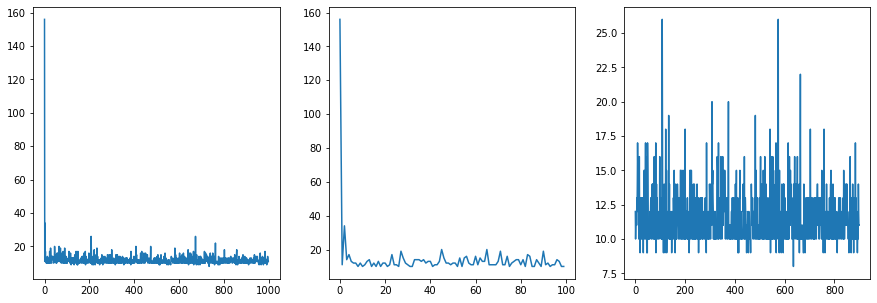

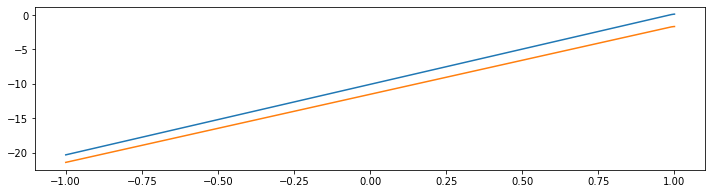

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)